In [ ]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [ ]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

/usr/local/lib/python3.6/dist-packages/osmnx/projection.py:62: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



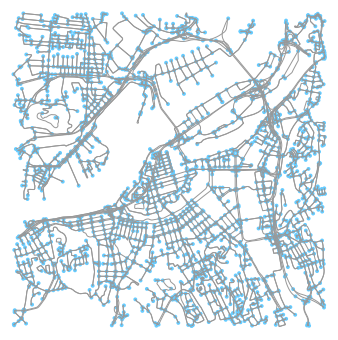

(<Figure size 803.641x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5b4c25ef0>)

In [ ]:
G = create_graph("Gothenburg", 2500, "drive", fig_width=12, fig_height=12)
ox.plot_graph(G)

In [ ]:
# impute missing edge speeds and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
start = (57.715495, 12.004210)
end = (57.707166, 11.978388)
start_node = ox.get_nearest_node(G, start) 
end_node = ox.get_nearest_node(G, end)
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
    


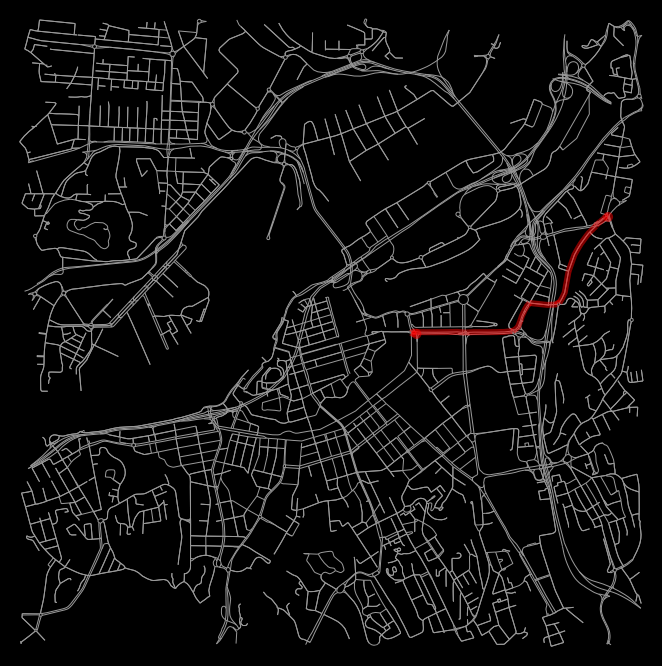

In [ ]:
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k',fig_width=12, fig_height=12 );

In [ ]:
nx.shortest_path_length?

In [ ]:
#see the travel time for the whole route
travel_time = nx.shortest_path_length(G, start_node, end_node, weight='travel_time')
print(round(travel_time))

158


In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,145173356,299734358,12.004177,57.715523,12.003816,57.715532,22,2
1,299734358,5061966869,12.003816,57.715532,12.003704,57.715463,10,1
2,5061966869,301823631,12.003704,57.715463,12.003085,57.715170,49,4
3,301823631,145181102,12.003085,57.715170,12.002536,57.714866,48,3
4,145181102,299823745,12.002536,57.714866,12.001726,57.714442,67,5


In [ ]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
0,0,145173356,299734358,12.004177,57.715523,12.003816,57.715532,22,2,POINT (12.00418 57.71552),POINT (12.0038159 57.7155324),"LINESTRING (12.0041766 57.7155229, 12.0038159 ..."
1,1,299734358,5061966869,12.003816,57.715532,12.003704,57.715463,10,1,POINT (12.00382 57.71553),POINT (12.0037041 57.7154625),"LINESTRING (12.0038159 57.7155324, 12.0037041 ..."
2,2,5061966869,301823631,12.003704,57.715463,12.003085,57.715170,49,4,POINT (12.00370 57.71546),POINT (12.0030851 57.7151705),"LINESTRING (12.0037041 57.7154625, 12.0030851 ..."
3,3,301823631,145181102,12.003085,57.715170,12.002536,57.714866,48,3,POINT (12.00309 57.71517),POINT (12.0025357 57.7148658),"LINESTRING (12.0030851 57.7151705, 12.0025357 ..."
4,4,145181102,299823745,12.002536,57.714866,12.001726,57.714442,67,5,POINT (12.00254 57.71487),POINT (12.0017258 57.714442),"LINESTRING (12.0025357 57.7148658, 12.0017258 ..."


In [ ]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

In [ ]:
line_gdf = create_line_gdf(df)

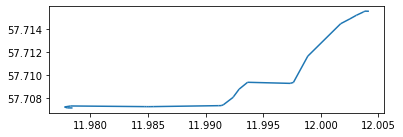

In [ ]:
line_gdf.plot()

In [ ]:
line_gdf.head()

,node_start,node_end,length,travel_time,line
0,145173356,299734358,22,2,"LINESTRING (12.00418 57.71552, 12.00382 57.71553)"
1,299734358,5061966869,10,1,"LINESTRING (12.00382 57.71553, 12.00370 57.71546)"
2,5061966869,301823631,49,4,"LINESTRING (12.00370 57.71546, 12.00309 57.71517)"
3,301823631,145181102,48,3,"LINESTRING (12.00309 57.71517, 12.00254 57.71487)"
4,145181102,299823745,67,5,"LINESTRING (12.00254 57.71487, 12.00173 57.71444)"


In [ ]:
df.tail()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
19,19,1374678095,7373669,11.984858,57.707243,11.984675,57.707246,11,1,POINT (11.98486 57.70724),POINT (11.9846746 57.7072458),"LINESTRING (11.9846746 57.7072458, 11.9848585 ..."
20,20,7373669,60890012,11.984675,57.707246,11.978290,57.707301,380,27,POINT (11.98467 57.70725),POINT (11.9782899 57.7073006),"LINESTRING (11.9782899 57.7073006, 11.9846746 ..."
21,21,60890012,25587532,11.978290,57.707301,11.977759,57.707214,34,2,POINT (11.97829 57.70730),POINT (11.9777595 57.7072137),"LINESTRING (11.9777595 57.7072137, 11.9782899 ..."
22,22,25587532,1375971951,11.977759,57.707214,11.978000,57.707135,17,1,POINT (11.97776 57.70721),POINT (11.9779997 57.7071347),"LINESTRING (11.9779997 57.7071347, 11.9777595 ..."
23,23,1375971951,314452681,11.978000,57.707135,11.978453,57.707129,27,2,POINT (11.97800 57.70713),POINT (11.9784529 57.7071286),"LINESTRING (11.9784529 57.7071286, 11.9779997 ..."


In [ ]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [ ]:
start

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
0,145173356,299734358,12.004177,57.715523,12.003816,57.715532,22,2,POINT (12.00418 57.71552),POINT (12.0038159 57.7155324),"LINESTRING (12.0041766 57.7155229, 12.0038159 ..."


In [ ]:
end

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
23,1375971951,314452681,11.978,57.707135,11.978453,57.707129,27,2,POINT (11.97800 57.70713),POINT (11.9784529 57.7071286),"LINESTRING (11.9779997 57.7071347, 11.9784529 ..."


In [ ]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])



In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=13, width=1000, height=800, animation_frame="index",mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [ ]:
fig.data

(Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'index=0<br>Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([57.7155229]),
     'legendgroup': '',
     'lon': array([12.0041766]),
     'marker': {'color': 'black', 'size': 12},
     'mode': 'markers',
     'name': '',
     'showlegend': False,
     'subplot': 'mapbox'
 }), Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([57.7155229]),
     'legendgroup': '',
     'lon': array([12.0041766]),
     'marker': {'color': 'red', 'size': 15},
     'mode': 'markers',
     'name': '',
     'showlegend': False,
     'subplot': 'mapbox'
 }), Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([57.7071347]),
     'legendgroup': '',
     'lon': array([11.9779997]),
     'marker': {'color': 'green', 'size': 15},
     'mode': 'markers',
     'name': '',
     'showlege